In [34]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tf
import math
import matplotlib as mpl
from scipy.stats import wilcoxon,mannwhitneyu
from statsmodels.stats.multitest import multipletests
import csv

In [35]:
file_folder_list_ach_1 = ['20230417-nsyb-G7f-rAch1h/fly2',
                        '20230420-nsyb-G7f-rAch1h/fly2',
                        '20230420-nsyb-G7f-rAch1h/fly3',
                        '20230428-nsyb-G7f-rAch1h/fly1',
                        '20230507-nsyb-G7f-rAch1h/fly1',
                        '20230510-nsyb-G7f-rAch1h/fly1',
                        '20230510-nsyb-G7f-rAch1h/fly2',
                        '20230511-nsyb-G7f-rAch1h/fly2',
                        '20230511-nsyb-G7f-rAch1h/fly3',
                        '20230515-nsyb-G7f-rAch1h/fly1']
file_folder_list_ach_2 = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', 
                 '20230507-fly1', '20230510-fly1', '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
file_folder_list_5ht_1 = ['20230429-nsyb-G7f-r5HT1.0/fly1',
                        '20230506-nsyb-G7f-r5HT1.0/fly1',
                        '20230513-nsyb-G7f-r5HT1.0/fly1',
                        '20230513-nsyb-G7f-r5HT1.0/fly2',
                        '20230516-nsyb-G7f-r5HT1.0/fly2',
                        '20230516-nsyb-G7f-r5HT1.0/fly4',
                        '20230517-nsyb-G7f-r5HT1.0/fly1',
                        '20230601-nsyb-G7f-r5HT1.0/fly1',
                        '20230601-nsyb-G7f-r5HT1.0/fly3',
                        '20230603-nsyb-G7f-r5HT1.0/fly1']
file_folder_list_5ht_2 = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', '20230513-r5HT1.0-fly2', 
                '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4', '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', 
                '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']

In [36]:
# choose the variable, channel, odor
# the flag_name changes with filename
filename = 'acc' # acc / auc_weighted / precision_weighted / recall_weighted / f1_weighted
channel_selected = 4 # 0-G7f combine, 1-g7f ach;2-g7f 5ht;3-ach, 4-5ht,5-both ach;6-both 5ht
odor_selected = 0
flag_name = 'Accuracy' 
if_save = True
if_p_corr = True
ratio = 1

# only left part
br_index = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]
br_name = np.array(['MBPED','MBVL','MBML','LH','SLP','SIP','SMP','CRE','SCL','ICL',
'NO','EB','FB','LAL','AOTU','AVLP','PVLP','IVLP','VES','GOR','SPS','EPA','FLA'])
br_olf = np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
print(len(br_index))
print(len(br_name))
print(len(br_olf))
the_color = ['black','coral']
the_color_list = []
for i in range(len(br_olf)):
    the_color_list.append(the_color[br_olf[i]])


23
23
23


In [37]:
## Ach
result_path = '../pipeline-revision/results/nsyb-G7f-rAch1h'
sub_path = 'Accuracy_map_DEEPCAD_formal'
atlas_path = '../data'
atlas_file_name = 'align_to_atlas/Transformed_atlas_eroded_r5.tif'
atlas_z_range = range(13,38)
win_x = 4
win_y = 4
win_z = 2

num_channel_choice = 3
num_odor_choice = 4
list_fly =  [0,1,2,3,4,5,6,7,8,9]###### choose fly
LH_none = [4]
num_fly = len(list_fly)
if if_save:
    figure_save_path = './results' + '/acc_map_statistics_new'
    folder = os.path.exists(figure_save_path)
    if not folder:
        os.makedirs(figure_save_path)

# compute 
list_acc = np.zeros((num_fly,len(br_index),num_channel_choice,num_odor_choice))
for i,id in enumerate(list_fly):
    # load map
    the_path = result_path + '/' + file_folder_list_ach_2[id] + '/' + sub_path + '/' + filename + '.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)

    # load atlas
    the_atlas_path = atlas_path + '/' + file_folder_list_ach_1[id] + '/' + atlas_file_name
    atlas= tf.imread(the_atlas_path)
    atlas = np.transpose(atlas,[1,2,0])
    atlas = atlas[:,:,atlas_z_range]
    atlas = atlas[range(int(win_x/2),np.size(atlas,0),win_x),:,:]
    atlas = atlas[:,range(int(win_y/2),np.size(atlas,1),win_y),:]
    atlas = atlas[:,:,range(0,np.size(atlas,2),win_z)]

    for j,index in enumerate(br_index):
        if j==3 and i in LH_none:
            continue
        mask = atlas == index
        if np.sum(mask)>0:
            flag = a[:,:,mask]
            if flag.ndim==3:
                if int(ratio*np.size(flag,2))>0:
                    flag = np.sort(flag,2)
                    flag = flag[:,:,::-1]
                    flag = flag[:,:,0:int(ratio*np.size(flag,2))]
                data = np.mean(flag,2)
            elif flag.ndim==2:
                data = flag 
            if num_odor_choice == 1:
                list_acc[i,j,:,0] = np.squeeze(data)
            else:
                list_acc[i,j,:,:] = data

list_acc_ach = list_acc

In [38]:
## 5ht
result_path = '../pipeline-revision/results/nsyb-G7f-r5HT1.0'
sub_path = 'Accuracy_map_DEEPCAD_formal'
atlas_path = '../data'
atlas_file_name = 'align_to_atlas/Transformed_atlas_eroded_r5.tif'
atlas_z_range = range(13,38)
win_x = 4
win_y = 4
win_z = 2

num_channel_choice = 3
num_odor_choice = 4
list_fly =  [0,1,2,3,4,5,6,7,8,9]###### choose fly
LH_none = [7]
num_fly = len(list_fly)

# compute 
list_acc = np.zeros((num_fly,len(br_index),num_channel_choice,num_odor_choice))
for i,id in enumerate(list_fly):
    # load map
    the_path = result_path + '/' + file_folder_list_5ht_2[id] + '/' + sub_path + '/' + filename + '.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)

    # load atlas
    the_atlas_path = atlas_path + '/' + file_folder_list_5ht_1[id] + '/' + atlas_file_name
    atlas= tf.imread(the_atlas_path)
    atlas = np.transpose(atlas,[1,2,0])
    atlas = atlas[:,:,atlas_z_range]
    atlas = atlas[range(int(win_x/2),np.size(atlas,0),win_x),:,:]
    atlas = atlas[:,range(int(win_y/2),np.size(atlas,1),win_y),:]
    atlas = atlas[:,:,range(0,np.size(atlas,2),win_z)]

    for j,index in enumerate(br_index):
        if j==3 and i in LH_none:
            continue
        mask = atlas == index
        if np.sum(mask)>0:
            flag = a[:,:,mask]
            if flag.ndim==3:
                if int(ratio*np.size(flag,2))>0:
                    flag = np.sort(flag,2)
                    flag = flag[:,:,::-1]
                    flag = flag[:,:,0:int(ratio*np.size(flag,2))]
                data = np.mean(flag,2)
            elif flag.ndim==2:
                data = flag 
            if num_odor_choice == 1:
                list_acc[i,j,:,0] = np.squeeze(data)
            else:
                list_acc[i,j,:,:] = data

list_acc_5ht = list_acc

In [39]:
if channel_selected==0:
    list_acc_selected = np.squeeze(np.concatenate((list_acc_ach[:,:,1,odor_selected],list_acc_5ht[:,:,1,odor_selected]),axis = 0))
elif channel_selected==1:
    list_acc_selected = np.squeeze(list_acc_ach[:,:,1,odor_selected])
elif channel_selected==2:
    list_acc_selected = np.squeeze(list_acc_5ht[:,:,1,odor_selected])
elif channel_selected==3:
    list_acc_selected = np.squeeze(list_acc_ach[:,:,2,odor_selected])
elif channel_selected==4:
    list_acc_selected = np.squeeze(list_acc_5ht[:,:,2,odor_selected])
elif channel_selected==5:
    list_acc_selected = np.squeeze(list_acc_ach[:,:,0,odor_selected])
else:
    list_acc_selected = np.squeeze(list_acc_ach[:,:,0,odor_selected])

list_acc_selected = list_acc_selected*100
print(np.shape(list_acc_selected))
num_fly = np.size(list_acc_selected,0)

(10, 23)


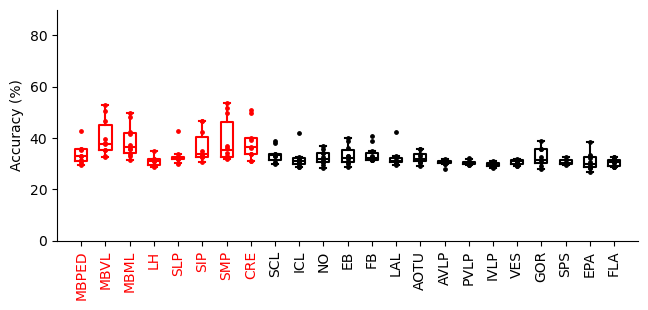

In [40]:
list_acc_selected_nonzero=[]
for j in range(len(br_index)):
    aa = np.squeeze(list_acc_selected[:,j])
    aa = aa[aa!=0]
    aa = aa.tolist()
    list_acc_selected_nonzero.append(aa)
list_acc_selected_nonzero = np.array(list_acc_selected_nonzero,object)
plt.figure(figsize = (7.5,3))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.boxplot(list_acc_selected_nonzero[br_olf==0][:],
            medianprops={'color': 'black', 'linewidth': '1.5'},
            # meanline=True,
            # showmeans=True,
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            showfliers=False,
            positions= np.squeeze(np.where(br_olf==0)),
            boxprops = {'color': 'black', 'linewidth': '1.5'},
            whiskerprops = {'color': 'black', 'linewidth': '1.5'},
            capprops =  {'color': 'black', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "black","markeredgecolor":"black", "markersize": 2})
plt.boxplot(list_acc_selected_nonzero[br_olf==1][:],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            # meanline=True,
            # showmeans=True,
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            showfliers=False,
            positions= np.squeeze(np.where(br_olf==1)),
            boxprops = {'color': 'red', 'linewidth': '1.5'},
            whiskerprops = {'color': 'red', 'linewidth': '1.5'},
            capprops =  {'color': 'red', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor":"red","markersize": 2})
for j in range(len(br_index)):
    for i in range(num_fly):
        if list_acc_selected[i,j]!=0:
            if br_olf[j]==1:
                plt.scatter(j,list_acc_selected[i,j],color = 'red',s = 6)
            else:
                plt.scatter(j,list_acc_selected[i,j],color = 'black',s = 6)
plt.xticks(range(len(br_index)),br_name,rotation=90)
plt.ylabel((flag_name + ' (%)'))
plt.xlim((-1,len(br_index)))
plt.ylim((0,90))
for j in range(len(br_index)):
    if br_olf[j]==1:
        plt.gca().get_xticklabels()[j].set_color('red') 
# if if_save:
#     mpl.rcParams['pdf.fonttype'] = 42
#     mpl.rcParams['ps.fonttype'] = 42
#     plt.savefig(figure_save_path + '/' + '3B_accuracy_map_region_' + filename + '_C'+str(channel_selected)+'_odor'+str(odor_selected)+'-box-ver.png',dpi = 300,bbox_inches = 'tight')
#     plt.savefig(figure_save_path + '/' + '3B_accuracy_map_region_' + filename + '_C'+str(channel_selected)+'_odor'+str(odor_selected)+'-box-ver.pdf',dpi = 300,bbox_inches = 'tight')
#     # plt.rcParams['svg.fonttype'] = 'none'
#     # plt.savefig(figure_save_path + '/' + '3B_accuracy_map_region_' + filename + '_C'+str(channel_selected)+'_odor'+str(odor_selected)+'-box.svg',dpi = 300,bbox_inches = 'tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.17570826 0.0034125  0.0034125  0.78102859 0.16088106 0.0072868
 0.00361051 0.00361051]
[0.17570826 0.0034125  0.0034125  0.78102859 0.16088106 0.0072868
 0.00361051 0.00361051]


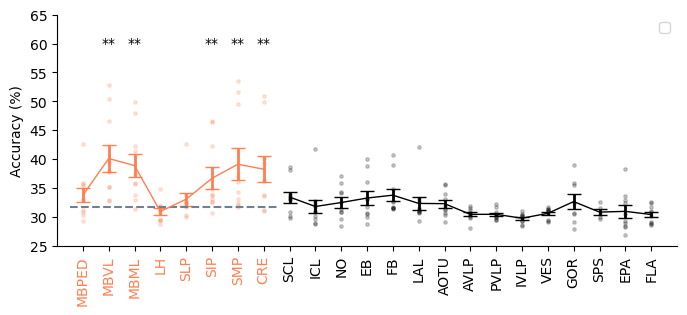

In [41]:
the_mean = np.zeros(len(br_index))
the_std = np.zeros(len(br_index))
for j in range(len(br_index)):
    aa = np.squeeze(list_acc_selected[:,j])
    the_mean[j] = np.mean(aa[aa!=0])
    the_std[j] = np.std(aa[aa!=0],ddof = 1)/math.sqrt(len(aa[aa!=0]))
plt.figure(figsize = (8,3))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.bar(np.squeeze(np.where(br_olf==1)), the_mean[br_olf==1], width=0.7,yerr = the_std[br_olf==1],error_kw = {'ecolor' : '0.2', 'capsize' :3 },
#                      alpha=0.7,facecolor = 'white',edgecolor='coral',linewidth=1.5,label = 'Olfactory Region')
# plt.bar(np.squeeze(np.where(br_olf==0)), the_mean[br_olf==0], width=0.7,yerr = the_std[br_olf==0],error_kw = {'ecolor' : '0.2', 'capsize' :3 },
#                      alpha=0.7,facecolor = 'white',edgecolor='black',linewidth=1.5,label = 'Others')
# for j in range(len(br_index)):
#     for i in range(num_fly):
#         if list_acc_selected[i,j]!=0:
#             plt.scatter(j,list_acc_selected[i,j],color = 'black',s = 6)

for j in range(len(br_index)):
        a = np.squeeze(list_acc_selected[:,j])
        plt.scatter(j*np.ones(num_fly),a,color = the_color_list[j],s = 6,alpha = 0.2)

## errorbar
plt.errorbar(np.squeeze(np.where(br_olf==1)),the_mean[br_olf==1],yerr=the_std[br_olf==1],ecolor='coral',elinewidth=2,marker='.',mfc='coral',\
mec='coral',mew=1,ms=1,alpha=1,capsize=5,capthick=3,color='coral', linewidth=1)   
plt.errorbar(np.squeeze(np.where(br_olf==0)),the_mean[br_olf==0],yerr=the_std[br_olf==0],ecolor='black',elinewidth=2,marker='.',mfc='black',\
mec='black',mew=1,ms=1,alpha=1,capsize=5,capthick=3,color='black', linewidth=1)  

# significance
list_acc_non_olf = list_acc_selected[:,br_olf==0]
list_acc_non_olf[list_acc_non_olf==0] = np.nan
list_acc_non_olf_mean = np.nanmean(list_acc_non_olf,1)
p_result = []
p_list = []
for i in range(len(br_name[br_olf==1])):
    a = np.squeeze(list_acc_selected[:,i])
    b = list_acc_non_olf_mean
    # b = b[a!=0]
    a = a[a!=0]
    res = mannwhitneyu(a,b,alternative = 'greater')
    p = res.pvalue
    p_list.append(p)
p_list = np.array(p_list)
if if_p_corr:
    p_corrected = multipletests(p_list,method = 'fdr_bh')
    p_list = p_corrected[1]
    print(p_list)
print(p_list)
for i in range(len(br_name[br_olf==1])):
    p = p_list[i]
    if p<0.05 and p>=0.01:
        plt.text(i,60,'*',verticalalignment = 'center', horizontalalignment = 'center')
    elif p<0.01 and p>0.001:
        plt.text(i,60,'**',verticalalignment = 'center', horizontalalignment = 'center')
    elif p<0.001 and p>=0.0001:
        plt.text(i,60,'***',verticalalignment = 'center', horizontalalignment = 'center') 
    elif p<0.0001:
        plt.text(i,60,'****',verticalalignment = 'center', horizontalalignment = 'center') 
p_result.append(p_list)

plt.plot([0-0.5,len(br_name[br_olf==1])-0.5],[np.mean(list_acc_non_olf_mean),np.mean(list_acc_non_olf_mean)],color = 'slategray',linestyle='--')
plt.xticks(range(len(br_index)),br_name,rotation=90)
plt.legend()
plt.ylabel((flag_name + ' (%)'))
plt.xlim((-1,len(br_index)))
plt.ylim((25,65))
for j in range(len(br_index)):
    if br_olf[j]==1:
        plt.gca().get_xticklabels()[j].set_color('coral') 
if if_save:
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.savefig(figure_save_path + '/' + 'accuracy_map_region_' + filename + '_C'+str(channel_selected)+'_odor'+str(odor_selected)+'-bar-ver.pdf',dpi = 300,bbox_inches = 'tight')
    plt.savefig(figure_save_path + '/' + 'accuracy_map_region_' + filename + '_C'+str(channel_selected)+'_odor'+str(odor_selected)+'-bar-ver.png',dpi = 300,bbox_inches = 'tight')
    with open(figure_save_path + '/' + 'accuracy_map_region_' + filename + '_C'+str(channel_selected)+'_odor'+str(odor_selected)+'-p.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(p_result)
plt.show()